# Inspect paired-end reads with short insert sizes

## Subproject overview

1. The commands in `script.sh` produce a SAM file that contains read pairs shorter than 35 bases. This notebook performs an analysis of short reads to determine their structure, with respeect to read pair orientation and soft clipping.

## Supporting code

In [1]:
import pysam
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Box print: Perhaps not needed. Use JupyterLab and resize the window big enough, can then display the full width.

from IPython.display import display, HTML
from pprint import pformat
def boxprint(*args):
    for arg in args:
        display(HTML('<pre style="white-space: pre !important;">{}</pre>'.format(arg)))

In [3]:
def skip_reads(bamfile, n):
    for _ in zip(range(n),bam.fetch()): pass # Skip a few reads

def get_read_pairs(bam, want_n_pairs, print_qname=False):
    reads = []
    for count, r in enumerate( bam.fetch()):
        if not r.is_read1 or r.mapping_quality < 20 or not r.is_proper_pair:
            continue
        try:
            m8 = bam.mate(r)
        except ValueError:
            continue
        if m8.mapping_quality < 20 or abs(m8.reference_start - r.reference_start) > 3000:
            continue
        if print_qname:
            print("\n", r.query_name)
        reads.append((r, m8))
        if len(reads) == want_n_pairs:
            break
    return reads

def get_start_end(read):
    """Locate start and end position in reference including soft-clipped bases."""
    
    SOFT_CLIP = 4
    start = read.reference_start
    if read.cigartuples[0][0] == SOFT_CLIP:
        start -= read.cigartuples[0][1]
    end = read.reference_end
    if read.cigartuples[-1][0] == SOFT_CLIP:
        end += read.cigartuples[-1][1]
    return (start, end)

In [4]:
bam = pysam.AlignmentFile("data/smallInserts.bam", "rb")
skip_reads(bam, 1000000)
reads_short_few = get_read_pairs(bam, 8)

In [5]:
for r1, r2 in reads_short_few:
    break # Set r1 and r2 to the first read pair

In [6]:
def pse(read):
    start, end = get_start_end(read)
    print (start, end, "length:", end - start)
pse(r1)
pse(r2)

10034 10185 length: 151
10153 10304 length: 151


In [7]:
r1.reference_start

10153

The following is is a function to display the reads in a nice way. Also showing output for the first read pair, as a test.

Use the `boxplot` function defined above to allow horizontal scrolling.

In [8]:
complement = {'A': 'T', 'T': 'A', 'G':'C', 'C': 'G'}

def show_reads(r1, r2):
    reads = [r1, r2]
    
    s, e = [0, 0], [0, 0]
    s[0], e[0] = get_start_end(reads[0])
    s[1], e[1] = get_start_end(reads[1])
    
    start = min(s)
    end = max(e)
    
    header = "|" + r1.reference_name + ":" + str(start) + " (ref length: " + str(end - start)  +\
                    ", tlen: " + str(r1.tlen) + "/" + str(r2.tlen) + ") " + r1.query_name
    
    if end - start > 3000: return header
    
    seqs = [r.query_sequence for r in reads]
    alignments = [
                {rpos: seq[spos] for (spos, rpos) in r.get_aligned_pairs() if spos != None}
                for (r,seq) in zip(reads, seqs)
    ]
    reference = {
        rpos: rbase.upper()
        for r in reads
        for (_, rpos, rbase) in r.get_aligned_pairs(with_seq=True) if rbase != None
    }
    refline = ""
    seqline = ["", ""]
    readline = ["", ""]
    matchline = ""
    
    for pos in range(start, end):
        base = [None, None]
        for i in [0,1]:
            if pos < s[i]:
                c = "."
            elif pos < reads[i].reference_start:
                c = seqs[i][pos - s[i]].lower()
            elif pos < reads[i].reference_end:
                c = alignments[i].get(pos)
                if c:
                    base[i] = c
                else:
                    c = '-'
            elif pos < e[i]:
                c = seqs[i][pos - e[i]].lower()
            else:
                c = "."
            seqline[i] += c
            if pos >= s[i] and pos < e[i]:
                if reads[i].is_reverse:
                    readline[i] += "<"
                else:
                    readline[i] += ">"
            else:
                readline[i] += " "
        if all(base) and base[0] == base[1]:
            matchline += "|"
        else:
            matchline += " "
        refline += reference.get(pos, '?')
    return "\n".join([header, refline, readline[0], seqline[0], matchline, seqline[1], readline[1]])
    
boxprint(show_reads(r1, r2))

In [9]:
boxprint("\n\n\n".join(show_reads(r1, r2) for r1, r2 in reads_short_few))

In [10]:
print(r1.is_read1, r2.is_read1)

True False


## Compare with a full bam file

Shows the same kind of visualization for the bam file before filtering out only small fragments

In [11]:
bam2 = pysam.AlignmentFile("../../20_piccard/Nextera-100ng-1.bam", "rb")
skip_reads(bam2, 1000000)
reads2 = get_read_pairs(bam2, 8)
boxprint("\n\n\n".join(show_reads(r1, r2) for r1, r2 in reads2))

## Input many reads from each file

For showing statistical relationships: soft clipping and template length below.

In [12]:
reads_short = get_read_pairs(bam, 1000)

In [13]:
reads_all = get_read_pairs(bam2, 1000)

In [14]:
def get_clipping_dataframe(reads):
    sclip = []
    for i, r1r2 in enumerate(reads):
        for j, r in enumerate(r1r2):
            clip_start, clip_end = 0, 0
            if r.cigartuples[0][0] == 4:
                clip_start = r.cigartuples[0][1]
            if r.cigartuples[-1][0] == 4:
                clip_end = r.cigartuples[-1][1]
            sclip.append({
                'pair': i,
                'is_r1': r.is_read1,
                'is_reverse': r.is_reverse,
                'clip_start': clip_start,
                'clip_end': clip_end,
                'is_clipped_start': clip_start != 0,
                'is_clipped_end': clip_end != 0,
                'tlen': r.tlen
            })
    return pd.DataFrame(sclip)

In [15]:
df_short = get_clipping_dataframe(reads_short)
df_short['file'] = 'short'
df_all = get_clipping_dataframe(reads_all)
df_all['file'] = 'all'
df = pd.concat([df_short, df_all])
df.head(n=2)

,clip_end,clip_start,is_clipped_end,is_clipped_start,is_r1,is_reverse,pair,tlen,file
0,0,119,False,True,True,True,0,-32,short
1,119,0,True,False,False,False,0,32,short


## Soft clipping stats

In [16]:
def make_count_heatmap(df, xcol, ycol, **kwargs):
    df_tmp = df[[xcol, ycol]].copy()
    df_tmp['one'] = 1
    df_heat = df_tmp.pivot_table(index=ycol, columns=xcol, values='one', aggfunc=np.sum)
    sns.heatmap(data=df_heat, annot=True, **kwargs)

### Which one is reversed

It seems to be random which of R1 and R2 is reversed and which is forward.

Text(0.5, 1, 'all reads')

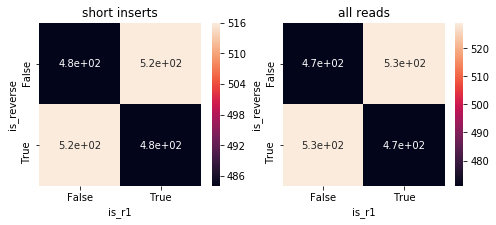

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
make_count_heatmap(df_short, 'is_r1', 'is_reverse', ax=axs[0])
axs[0].set_title('short inserts')
make_count_heatmap(df_all, 'is_r1', 'is_reverse', ax=axs[1])
axs[1].set_title('all reads')

### Clipping plots
Here's a function to plot information about clipping, which will then be applied to both dataframes -- "all" and "short".

In [18]:
def make_clipping_plots(df):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    sns.scatterplot(ax=axs[0], data=df, x='clip_start', y='clip_end', hue='is_r1')
    sns.scatterplot(ax=axs[1], data=df, x='clip_start', y='clip_end', hue='is_reverse')
    make_count_heatmap(df, 'is_clipped_start', 'is_clipped_end', ax=axs[2])
    fig.show()

Short inserts


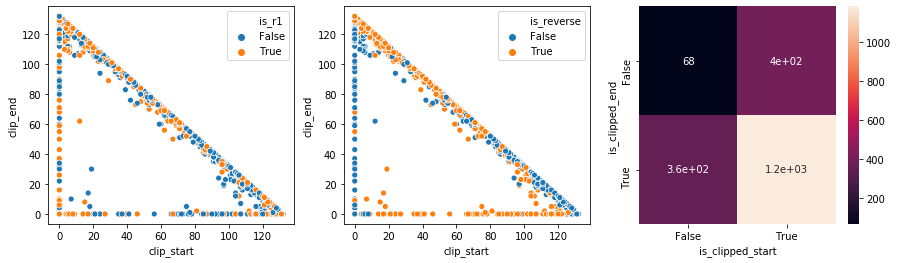

In [19]:
print("Short inserts")
make_clipping_plots(df_short)

Text(0.5, 1.0, 'remaining length after clipping')

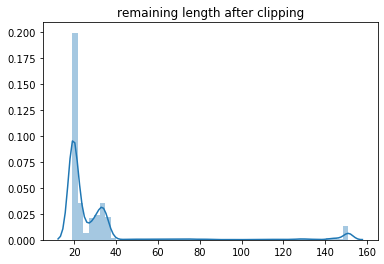

In [20]:
sns.distplot(151-(df_short.clip_start+df_short.clip_end))
plt.title('remaining length after clipping')

All reads


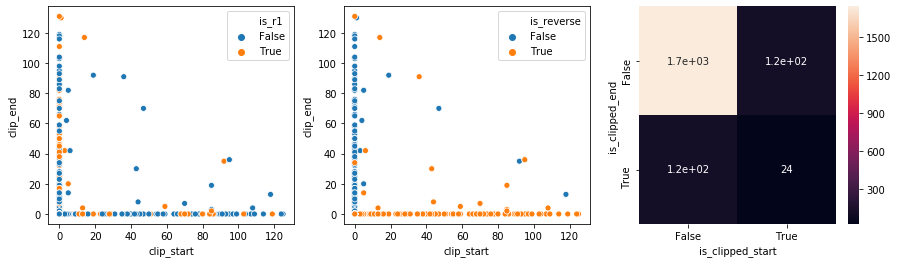

In [21]:
print("All reads")
make_clipping_plots(df_all)

Result:
* Short insert reads are clipped in both ends. Most are clipped such that the remaining length is 20.
* Other reads ("all") are generally not clipped, and are unlikely to be clipped in both ends.
* Reads in reverse orientation are generally clipped in the start of the sequence, and reads in forward orientation at end of sequence.

### R1-R2 correlations

Maybe check in the future (will need a join or a different dataframe).

## Template length

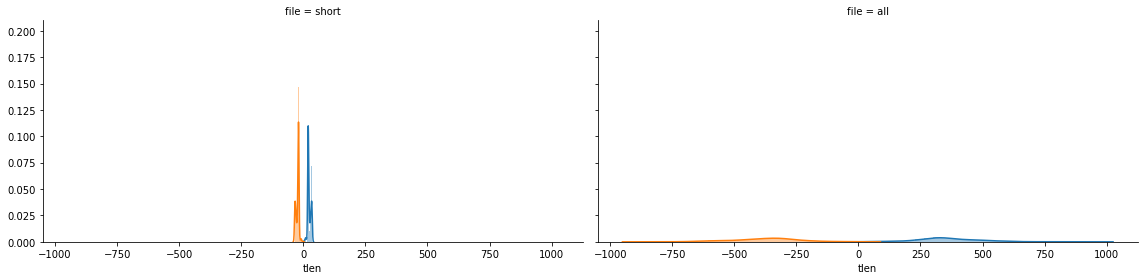

In [22]:
fg = sns.FacetGrid(data=df[df.is_r1], col='file', height=4, aspect=2, hue='is_reverse')
fg.map(sns.distplot, 'tlen')